# Instantaneous point source analysis

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Define inputs and load data

In [2]:
# user inputs ------------------------------------

# data file containing the arrays t_sec and C_mgL
datafile = 'tracer9upM.csv'

# known properties of stream at the time of data collection
A1 = 4            # cross sectional flow area ft^2
U1 = 0.08         # cross sectional average velocity ft/s
K1 = 1.08         # measured dispersion coefficient ft^2/s
h1 = 1            # average depth ft 
S = 0.010         # average slope ft/ft
M_mg = 8000000    # total mass of salt added mg
xknown1 = 200     # distance to source if known

# factor of Cmax for the calculation of time from break to Cmax
breakfactor = 0.5 

# range of C curve to start pulling data for slope calc
Clower = 0.30 
Cupper = 0.70

# calculate and load file ------------------------

# convert to SI
ft_m = (30.48/100)
A = A1*ft_m**2 # puts in m
U = U1*ft_m
K = K1*ft_m**2
h = h1*ft_m
M = M_mg/1000 # to grams
xknown = xknown1*ft_m

ustar = sqrt(9.81*h*S)
Kcalc = 6*ustar*h
print('K given [m2/s] =', around(K,decimals = 2))
print('K calc [m2/s] =', around(Kcalc, decimals = 2))

data = pd.read_csv(datafile)

t=array(data.t_sec)+1 # 1 second is added to the data to avoid issues with t = 0 in the calcs
C=array(data.C_mgL)

data.head() # preview of the first 5 rows of data loaded

K given [m2/s] = 0.1
K calc [m2/s] = 0.32


,t_sec,cond_microS_cm,C_mgL
0,0,717,0.0
1,60,717,0.0
2,120,717,0.0
3,180,716,0.0
4,240,716,0.0


## Plot the data
### Raw data

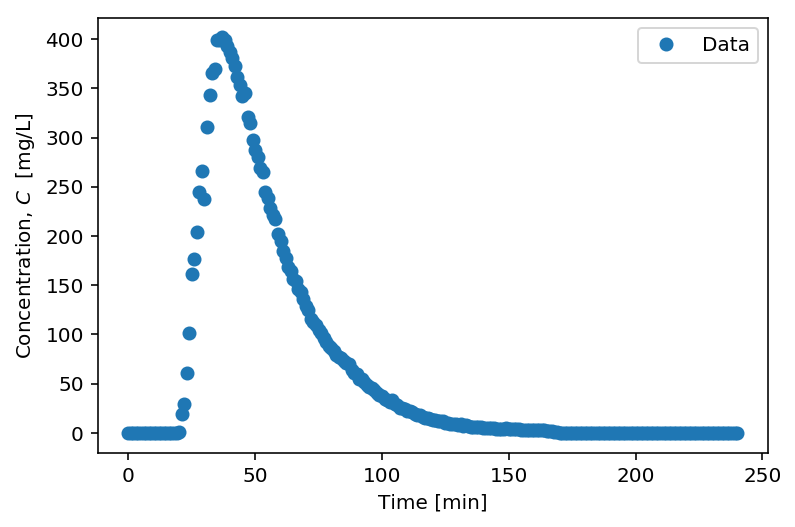

In [3]:
fig, ax = plt.subplots()
ax.plot(t/60,C,'o', label='Data')
ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentration, $C$  [mg/L]')
legend(loc=1);

### Zoom into the leadin $C=C(t)$ front and calculate key properties

Key times --------------
time to 0.5Cmax [min] = 27.02
time to peak [min] = 37.02
time from 0.5Cmax to peak [min]= 10.0

C=C(t) front slope --------------
slope of dC/dt between 0.3Cmax and 0.7Cmax = 0.42

Distance estimates --------------
L based on U and tpeak [m] = 54.16
L based on U and tpeak [ft] = 177.68


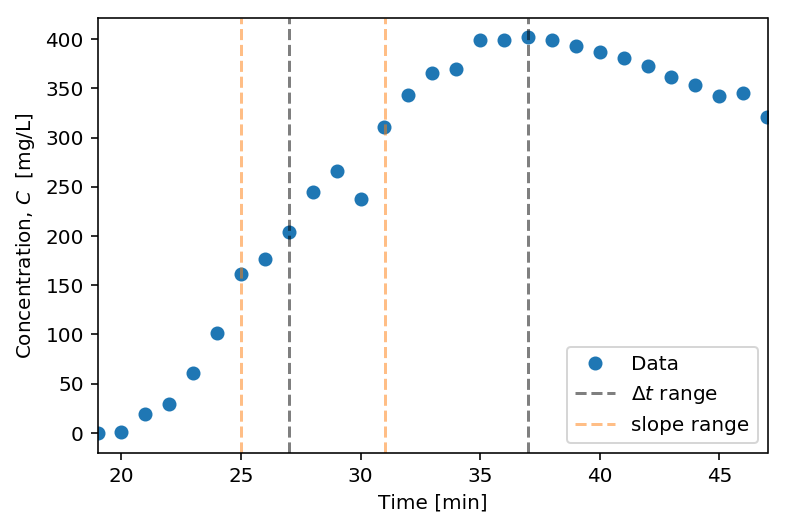

In [4]:
Cmax = amax(C) # maximium concentraiton observed

# calculate times and delta times
tstart = t[nonzero(C > 0.01*Cmax)[0][0]] # time location of the initial front
tpeak = t[argmax(C)] # time of the peak
tbreak = t[nonzero(C > breakfactor*Cmax)[0][0]] # time of the value to calculate dt from
Dtmeas = tpeak - tbreak

# calculate the slope of the leading front
indx1 = nonzero(C > Clower*Cmax)[0][0]
indx2 = nonzero(C > Cupper*Cmax)[0][0]
t1 = t[indx1]
t2 = t[indx2]
dCdtmeas = (C[indx2]-C[indx1])/(t2-t1)

Xstart = tpeak*U

breakpt = str(breakfactor)+'Cmax'
sloperange='slope of dC/dt between '+str(Clower)+'Cmax and '+str(Cupper)+'Cmax'

print('Key times --------------')
print('time to '+breakpt+' [min] =', around(tbreak/60,decimals=2))
print('time to peak [min] =', around(tpeak/60,decimals=2))
print('time from '+breakpt+' to peak [min]=', around(Dtmeas/60,decimals=2))
print('')
print('C=C(t) front slope --------------')
print(sloperange+' =',around(dCdtmeas,decimals=2))
print('')
print('Distance estimates --------------')
print('L based on U and tpeak [m] =', around(tpeak*U,decimals=2))
print('L based on U and tpeak [ft] =', around(tpeak*U/ft_m,decimals=2))

fig, ax = plt.subplots()
ax.plot(data.t_sec/60,data.C_mgL,'o', label='Data')

ax.axvline(x=tbreak/60,color='k', linestyle='--', alpha=0.5, label='$\Delta t$ range')
ax.axvline(x=tpeak/60,color='k', linestyle='--', alpha=0.5)

ax.axvline(x=t1/60,color='C1', linestyle='--', alpha=0.5, label='slope range')
ax.axvline(x=t2/60,color='C1', linestyle='--', alpha=0.5)

ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentration, $C$  [mg/L]')
ax.set_xlim(tstart/60-2,tpeak/60+10)
legend(loc=4);

## Fit the data to the Taylor solution

### Define Taylors solutions with different levels of input

In [5]:
def taylor(t,K,x):
    Cp = (M/(A*sqrt(4*pi*K*t)))*exp(-(x-U*t)**2/(4*K*t))
    return Cp # returns C in mg/L

def taylor2(t,K):
    x=Xstart
    Cp = (M/(A*sqrt(4*pi*K*t)))*exp(-(x-U*t)**2/(4*K*t))
    return Cp # returns C in mg/Lpopt

def taylorU(t,M,U,K,x):
    Cp = (M/(A*sqrt(4*pi*K*t)))*exp(-(x-U*t)**2/(4*K*t))
    return Cp # returns C in mg/L

### Fit Taylor's equation to the data using $K$ and $x_{\mathit{start}}$ as fit parameters 

given dispersion coef [m2/s] 0.1
fit dispersion coef [m2/s] 0.11
fit distance in [m] 63.0
fit distance in [ft] 207.0


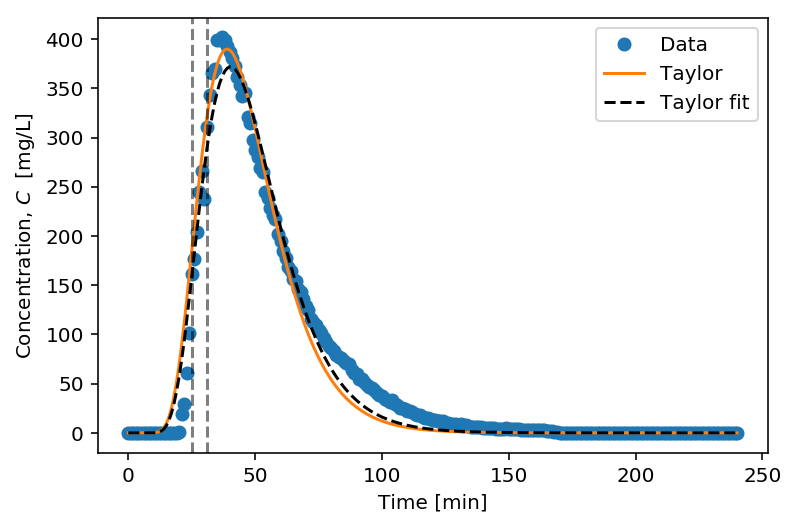

In [6]:
# define upper bounds for the fit
kup = 20. # uppper bound on K 
xup = 200. # upper bound on x_start 

# perform the fit
popt, cov = curve_fit(taylor, t, C, bounds=(0.,[kup,xup]))

# plot the data, the fit, and the model using K given
fig, ax = plt.subplots()
ax.plot(t/60,C,'o', label='Data')
ax.plot(t/60,taylor(t,K,xknown), label='Taylor')
ax.plot(t/60,taylor(t,popt[0],popt[1]), '--k', label='Taylor fit')

# add in the lines about where the slope will be calculated
ax.axvline(x=t1/60,color='k', linestyle='--', alpha=0.5)
ax.axvline(x=t2/60,color='k', linestyle='--', alpha=0.5)

ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentration, $C$  [mg/L]')
legend(loc=1);

Kfit = popt[0]
xfit = popt[1]
print('given dispersion coef [m2/s]',around(K,decimals=2))
print('fit dispersion coef [m2/s]',around(popt[0],decimals=2))
print('fit distance in [m]',around(popt[1],decimals=0))
print('fit distance in [ft]',around(popt[1]/ft_m,decimals=0))

## Examine anlytic solution to Taylors at various $x_{\mathit{start}}$, $U$, and $M$ values

time to 0.5Cmax [min] = 25.45
time to peak [min] = 38.96
Dt = tpeak - tbreak [min] = 13.51
slope of dC/dt between 0.3Cmax and 0.7Cmax = 0.41


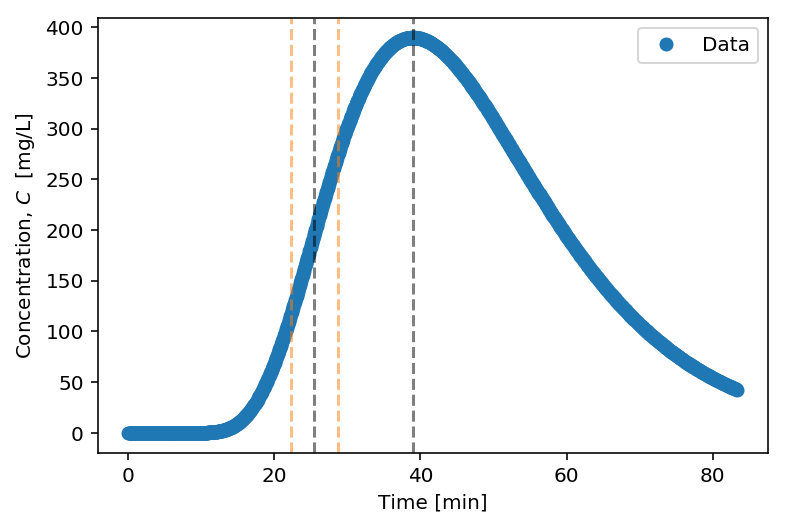

In [7]:
xtest = 200*ft_m
Utest = 0.08*ft_m
Mtest = M

N = 1000
tend = 2*(xtest/Utest)
tsyn = linspace(1,tend, N)

Ctest = taylorU(tsyn,Mtest,Utest,K,xtest)

Cmax = amax(Ctest)
tpeak = tsyn[argmax(Ctest)]
tbreak = tsyn[nonzero(Ctest > breakfactor*Cmax)[0][0]]
dttest = tpeak - tbreak

indx1 = nonzero(Ctest > Clower*Cmax)[0][0]
indx2 = nonzero(Ctest > Cupper*Cmax)[0][0]
dCdt = (Ctest[indx2]-Ctest[indx1])/(tsyn[indx2]-tsyn[indx1])

print('time to '+breakpt+' [min] =', around(tbreak/60,decimals=2))
print('time to peak [min] =', around(tpeak/60,decimals=2))
print('Dt = tpeak - tbreak [min] =', around(dttest/60,decimals=2))
print(sloperange+' =', around(dCdt,decimals =2))

fig, ax = plt.subplots()
ax.plot(tsyn/60,Ctest,'o', label='Data')

ax.axvline(x=tbreak/60,color='k', linestyle='--', alpha=0.5)
ax.axvline(x=tpeak/60,color='k', linestyle='--', alpha=0.5)

ax.axvline(x=tsyn[indx1]/60,color='C1', linestyle='--', alpha=0.5)
ax.axvline(x=tsyn[indx2]/60,color='C1', linestyle='--', alpha=0.5)

ax.set_xlabel('Time [min]')
ax.set_ylabel('Concentration, $C$  [mg/L]')
legend(loc=1);

## Examine $\Delta t$ for a range of $x_{\mathit{start}}$ and $U$ values

The propose of this section is to demonstrate that both $\Delta t$ and the slope of the concentration front $dC/dt$ are smooth and monotonic functions of $x_{\mathit{start}}$ for a given $U$ and $K$ values

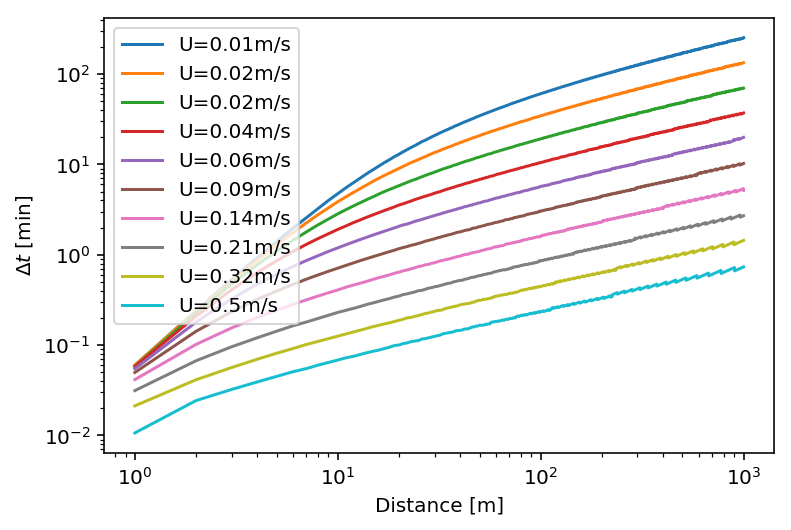

In [8]:
# find dt for different x values

N = 1000
xrange = linspace(1,1000,N)
dt = zeros(N)

Velpts = 10
Umin = 0.01
Umax = 0.5
Urange = geomspace(Umin,Umax,Velpts)
#Urange = array([0.01,0.02,0.03])

fig, ax = plt.subplots()

for j in range(0,Velpts):
    for i in range(0,N):
        
        tend = 2*(xrange[i]/Urange[j])
        tsyn = linspace(1,tend, N)
        Csyn = taylorU(tsyn,M,Urange[j],K,xrange[i])
        
        Cmax = amax(Csyn)
        tpeak = tsyn[argmax(Csyn)]
        tbreak = tsyn[nonzero(Csyn > breakfactor*Cmax)[0][0]]
        dt[i] = tpeak - tbreak
        
        uvel = 'U='+str(around(Urange[j],decimals=2))+'m/s'

    ax.plot(xrange,dt/60, label=uvel)

    
ax.set_xlabel('Distance [m]')
ax.set_ylabel('$\Delta t$ [min]')
ax.set_yscale('log')
ax.set_xscale('log')
legend(loc=2);

## Estimate $x_{\mathit{start}}$ using Taylors equation

Here we use the analytic solution to Taylors equation for a large range of $x_{\mathit{start}}$ values to determine which $x_{\mathit{start}}$ value give us a slope and $\Delta t$ value closest to the one observed.

Estimating distance using dt -------
Known time from breakthrough to peak [min] = 10.0
Likely distance to source [m] = 40.0
Likely distance to source [ft] = 131.0

Estimating distance using dCdt -------
Known dCdt fro data [mg/L-s] = 0.0
Likely distance to source [m] = 60.0
Likely distance to source [ft] = 197.0


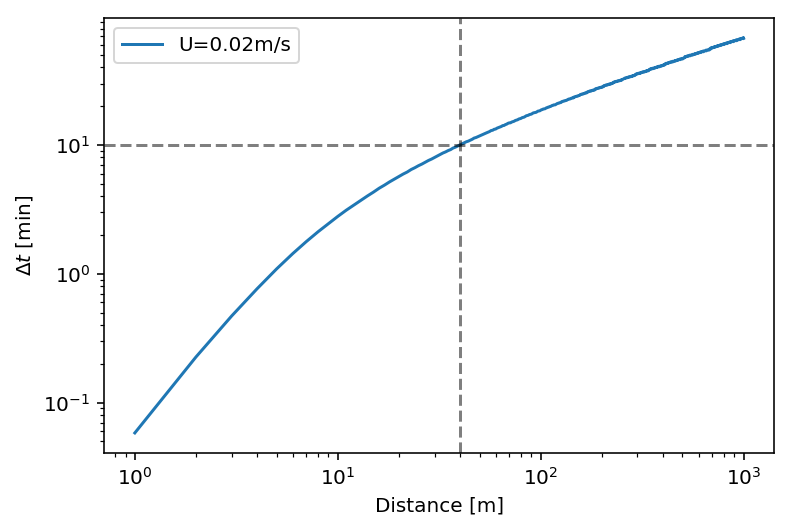

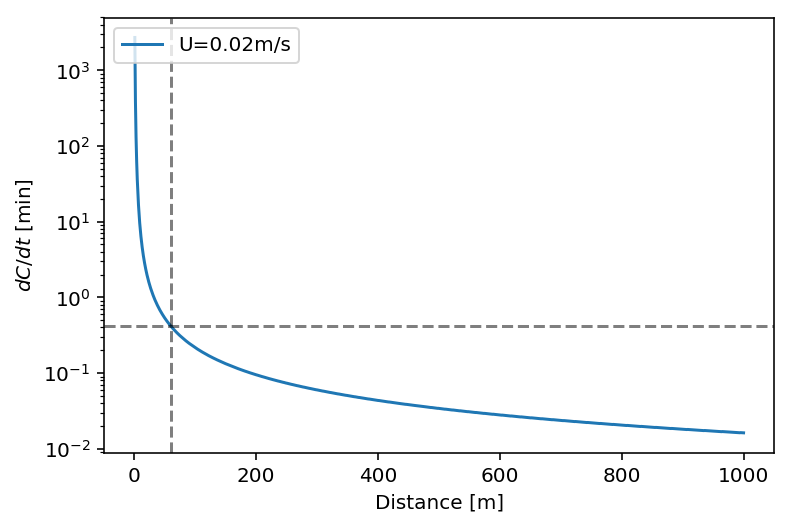

In [10]:
# user input

U2 = U
K2 = K
M2 = M
Dt2 = Dtmeas # enter the number of sec for dt
dCdt2 = dCdtmeas

# build Dt values

N = 1000
xrange = linspace(1,1000,N)
dt = zeros(N)
dCdt = zeros(N)

for i in range(0,N):
    tend = 2*(xrange[i]/U2)
    tsyn = linspace(1,tend, N)
    Csyn = taylorU(tsyn,M2,U2,K2,xrange[i])
    Cmax = amax(Csyn)
    tpeak = tsyn[argmax(Csyn)]
    tbreak = tsyn[nonzero(Csyn > breakfactor*Cmax)[0][0]]
    dt[i] = tpeak - tbreak
    
    indx1 = nonzero(Csyn > Clower*Cmax)[0][0]
    indx2 = nonzero(Csyn > Cupper*Cmax)[0][0]
    t1 = tsyn[indx1]
    t2 = tsyn[indx2]
    dCdt[i] = (Csyn[indx2]-Csyn[indx1])/(t2-t1)

idx_dt = (np.abs(dt-Dt2)).argmin()
xloc_dt = xrange[idx_dt]

idx_dcdt = (np.abs(dCdt-dCdt2)).argmin()
xloc_dcdt = xrange[idx_dcdt]

print('Estimating distance using dt -------')
print('Known time from breakthrough to peak [min] =', Dt2/60)
print('Likely distance to source [m] =', around(xloc_dt,decimals=0))
print('Likely distance to source [ft] =', around(xloc_dt/ft_m,decimals=0))
print('')
print('Estimating distance using dCdt -------')
print('Known dCdt fro data [mg/L-s] =', around(dCdt2))
print('Likely distance to source [m] =', around(xloc_dcdt,decimals=0))
print('Likely distance to source [ft] =', around(xloc_dcdt/ft_m,decimals=0))


# plot dt vs distance -----
fig, ax = plt.subplots()  

uvel = 'U='+str(around(U2,decimals=2))+'m/s'
ax.plot(xrange,dt/60, label=uvel)

ax.axvline(x=xloc_dt,color='k', linestyle='--', alpha=0.5)
ax.axhline(y=Dt2/60,color='k', linestyle='--', alpha=0.5)
  
ax.set_xlabel('Distance [m]')
ax.set_ylabel('$\Delta t$ [min]')
ax.set_yscale('log')
ax.set_xscale('log')
legend(loc=2);

# plot slope of line dCdt vs distance -----

fig, ax = plt.subplots()  

uvel = 'U='+str(around(U2,decimals=2))+'m/s'
ax.plot(xrange,dCdt, label=uvel)

ax.axvline(x=xloc_dcdt,color='k', linestyle='--', alpha=0.5)
ax.axhline(y=dCdt2,color='k', linestyle='--', alpha=0.5)
  
ax.set_xlabel('Distance [m]')
ax.set_ylabel('$dC/dt$ [min]')
ax.set_yscale('log')
# ax.set_xscale('log')
legend(loc=2);
